In [1]:
import sys
sys.path.append('/home/aklantbhowmick/anaconda3/lib/python3.7/site-packages')
sys.path.append('/home/aklantbhowmick/anaconda3/lib/python3.7/site-packages/scalpy/')
sys.path.append('/home/aklantbhowmick/anaconda3/envs/nbodykit-env/lib/python3.6/site-packages/')
import site

import arepo_package
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [43]:
def find_BH_position(basePath,desired_redshift,p_id=1002600983,choose_most_massive=0): 
    bh_IDs,output_redshift=arepo_package.get_particle_property(basePath,'ParticleIDs',5,desired_redshift,list_all=False)
    bh_positions,output_redshift=arepo_package.get_particle_property(basePath,'Coordinates',5,desired_redshift,list_all=False)       
    bh_masses,output_redshift=arepo_package.get_particle_property(basePath,'Masses',5,desired_redshift,list_all=False)
    #print(bh_positions,bh_masses)
    if (choose_most_massive):
        center=bh_positions[bh_masses==numpy.amax(bh_masses)]
    else:
        center=(bh_positions[bh_IDs==p_id])
    return center

def orient_plane(positions,perpendicular_vector):
    def mag(vector):
        return numpy.sqrt(sum(vector**2))    
    A=numpy.array([1,1,1])
    unit_A=A/mag(A)
    unit_perpendicular_vector=perpendicular_vector/mag(perpendicular_vector)
    
    L=unit_perpendicular_vector      
    LxA=numpy.cross(L,unit_A)
    LxLxA=numpy.cross(L,LxA)
    
    LxA/=mag(LxA)
    LxLxA/=mag(LxLxA)
    
    zpos_new=numpy.dot(positions,L)
    
    xpos_new=numpy.dot(positions,LxA)
    
    ypos_new=numpy.dot(positions,LxLxA)


    #print(numpy.dot(L,LxA))
    #print(numpy.dot(L,LxLxA))
    #print(numpy.dot(LxA,LxLxA))    
    #print(mag(L),mag(LxA),mag(LxLxA))
    new_positions=numpy.transpose(numpy.array([xpos_new,ypos_new,zpos_new]))
    #print(new_positions)
    return new_positions
    
    

def extract_slice(basePath,p_type,desired_center,desired_redshift,planeofsky_dimensions=(1000,1000),lineofsight_dimension=20,plane='xy',orient=0):
    positions,output_redshift=arepo_package.get_particle_property(basePath,'Coordinates',p_type,desired_redshift,list_all=False)       
    masses,output_redshift=arepo_package.get_particle_property(basePath,'Masses',p_type,desired_redshift,list_all=False)
   
    positions_relative_to_center=positions-desired_center
    if (orient):
        positions_relative_to_center=orient_plane(positions_relative_to_center,perpendicular_vector)
    
    if (plane=='xy'):
        planeofsky_pos1=positions_relative_to_center[:,0]
        planeofsky_pos2=positions_relative_to_center[:,1]
        lineofsight_pos=positions_relative_to_center[:,2]
        
    if (plane=='xz'):
        planeofsky_pos1=positions_relative_to_center[:,0]
        planeofsky_pos2=positions_relative_to_center[:,2]
        lineofsight_pos=positions_relative_to_center[:,1]
    
    if (plane=='yz'):
        planeofsky_pos1=positions_relative_to_center[:,1]
        planeofsky_pos2=positions_relative_to_center[:,2]
        lineofsight_pos=positions_relative_to_center[:,0]
        
    observable_positions=numpy.transpose(numpy.array([planeofsky_pos1,planeofsky_pos2,lineofsight_pos]))
    
    mask_planeofsky_1=numpy.abs(planeofsky_pos1)<planeofsky_dimensions[0]/2
    mask_planeofsky_2=numpy.abs(planeofsky_pos2)<planeofsky_dimensions[1]/2
    mask_lineofsight=numpy.abs(lineofsight_pos)<lineofsight_dimension/2
    mask=(mask_planeofsky_1&mask_planeofsky_2)&mask_lineofsight
        
    return observable_positions[mask],masses[mask]

def visualize(final_positions,final_property,number_of_pixels,get_density=0):
    n_planeofsky1=number_of_pixels
    n_planeofsky2=number_of_pixels
    planeofsky_pos1=final_positions[:,0]
    planeofsky_pos2=final_positions[:,1]
    lineofsight_pos=final_positions[:,2]
    

    
    planeofsky1_grid=numpy.linspace(min(planeofsky_pos1),max(planeofsky_pos1),n_planeofsky1)
    planeofsky2_grid=numpy.linspace(min(planeofsky_pos2),max(planeofsky_pos2),n_planeofsky2)
    pixelsize_planeofsky1=numpy.diff(planeofsky1_grid)[0]
    pixelsize_planeofsky2=numpy.diff(planeofsky2_grid)[0]
    pixelsize_lineofsight=numpy.amax(lineofsight_pos)-numpy.amin(lineofsight_pos)

    proj_property=[]
    if (get_density):
        pixel_volume=pixelsize_lineofsight*pixelsize_planeofsky1*pixelsize_planeofsky2

 
    First,Second=numpy.meshgrid(planeofsky1_grid,planeofsky2_grid)
    for pixel_position2 in planeofsky2_grid:
        for pixel_position1 in planeofsky1_grid:
            mask1=(planeofsky_pos1>(pixel_position1-pixelsize_planeofsky1/2.0))&(planeofsky_pos1<(pixel_position1+pixelsize_planeofsky1/2.))
            mask2=(planeofsky_pos2>(pixel_position2-pixelsize_planeofsky2/2.0))&(planeofsky_pos2<(pixel_position2+pixelsize_planeofsky2/2.))
       
            mask=(mask1) & (mask2)
            if (get_density):
                proj_property.append(numpy.sum(final_property[mask])/pixel_volume)
            else:
                proj_property.append(numpy.average(final_property[mask]))                   
    proj_property=numpy.asarray(proj_property)
    print(proj_property)
    #proj_property[proj_property==0]=1e-19
    Proj_property=proj_property.reshape(number_of_pixels,number_of_pixels)

    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    

    if (get_density):
        print("making")
        fig_object=ax.pcolor(First,Second,Proj_property,norm=mpl.colors.LogNorm(vmin=min(proj_property[proj_property>0]),vmax=Proj_property.max()),cmap='Greys_r')
        cbar=fig.colorbar(fig_object,ax=ax)
        cbar.set_label('log gas density ($M_{\odot}/(cKpc/h)^3$)',fontsize=30)
        #if projection_plane=='xy':
        ax.set_xlabel('Plane of sky 1',fontsize=30)
        ax.set_ylabel('Plane of sky 2',fontsize=30)
            #bh=plt.Circle((bhcoord[0],bhcoord[1]),0.5,color='black')
        #ax.add_artist(bh)

    #plt.title(title_name)
    #fig.savefig(save_name)

def stellar_ang_mom(basePath,desired_redshift,desired_center,box_length=40):
    p_type=4
    positions,output_redshift=arepo_package.get_particle_property(basePath,'Coordinates',p_type,desired_redshift,list_all=False)       
    masses,output_redshift=arepo_package.get_particle_property(basePath,'Masses',p_type,desired_redshift,list_all=False)
    velocities,output_redshift=arepo_package.get_particle_property(basePath,'Velocities',p_type,desired_redshift,list_all=False)
    masses*=1e10
    velocities/=3.0886e16
    
    xvel=velocities[:,0] #units switched from km/s to kpc/s
    yvel=velocities[:,1]
    zvel=velocities[:,2]

    xpos=positions[:,0]
    ypos=positions[:,1]
    zpos=positions[:,2]
    
    center=desired_center[0]
    
    mask_x=numpy.abs(xpos-center[0])<box_length/2
    mask_y=numpy.abs(ypos-center[1])<box_length/2
    mask_z=numpy.abs(zpos-center[2])<box_length/2
    mask=(mask_x&mask_y)&mask_z
    
    xvel=xvel[mask]
    yvel=yvel[mask]
    zvel=zvel[mask]
    
    xpos=xpos[mask]
    ypos=ypos[mask]
    zpos=zpos[mask]
    
    masses=masses[mask]

    #Calculate angular momentum
    Lx=(ypos*zvel-zpos*yvel)*masses
    Lx=sum(Lx)
    Ly=(xpos*zvel-zpos*xvel)*masses
    Ly=sum(Ly)
    Lz=(xpos*yvel-ypos*xvel)*masses
    Lz=sum(Lz)    
    L_total=numpy.transpose(numpy.array([Lx,Ly,Lz]))
     
    p_particles=numpy.transpose(numpy.array([xvel*masses,yvel*masses,zvel*masses]))


    p_gal=numpy.sum(p_particles,axis=0)

    num=numpy.transpose(numpy.array([xpos*masses,ypos*masses,zpos*masses]))
    com=numpy.sum(num,axis=0)/numpy.sum(masses)


    L_orbital=numpy.cross(com,p_gal)

     
    L_spin=L_total-L_orbital


    return L_spin


/apps/jupyterhub/1.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]


[0. 0. 0. ... 0. 0. 0.]
making


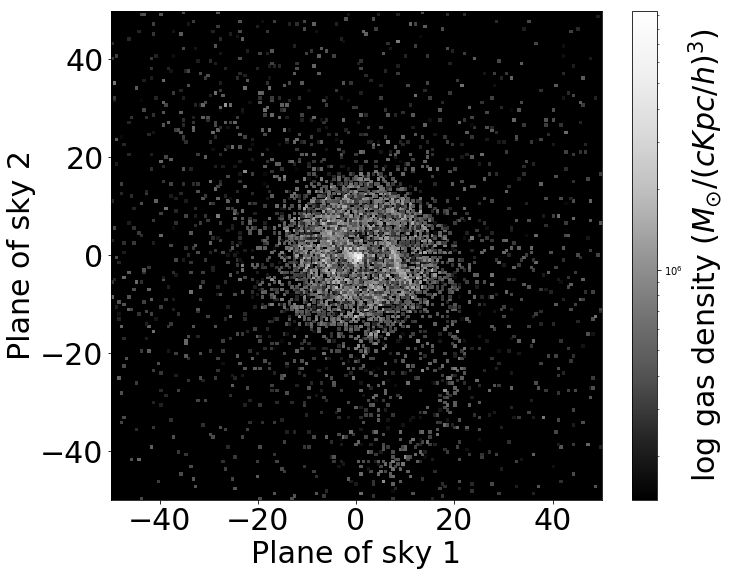

In [49]:
path_to_run='/ufrc/lblecha/aklantbhowmick/NEW_AREPO_RUNS/'
run='L25n128MUSIC_rerun_zoom_levelmax9_haloindex100_redshift0.00/AREPO'
basePath=path_to_run+run+'/output_BH_NGB_256/'
desired_redshift=0.2
unit_conversions=1e10
BH_index=0
plane='xy'
bh_IDs,output_redshift=arepo_package.get_particle_property(basePath,'ParticleIDs',5,desired_redshift,list_all=False)
desired_center=find_BH_position(basePath,desired_redshift,p_id=bh_IDs[BH_index],choose_most_massive=0)
perpendicular_vector=stellar_ang_mom(basePath,desired_redshift,desired_center)
final_positions,final_property=extract_slice(basePath,0,desired_center,desired_redshift,planeofsky_dimensions=(100,100),lineofsight_dimension=20,plane=plane,orient=1)
final_property*=unit_conversions
final_property=='Density'
fig, ax = plt.subplots(1,1,figsize=(11,9))
ax.set_facecolor('xkcd:black')
visualize(final_positions,final_property,200,get_density=1)
ax.tick_params(labelsize=30)

/apps/jupyterhub/1.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


[0. 0. 0. ... 0. 0. 0.]
making


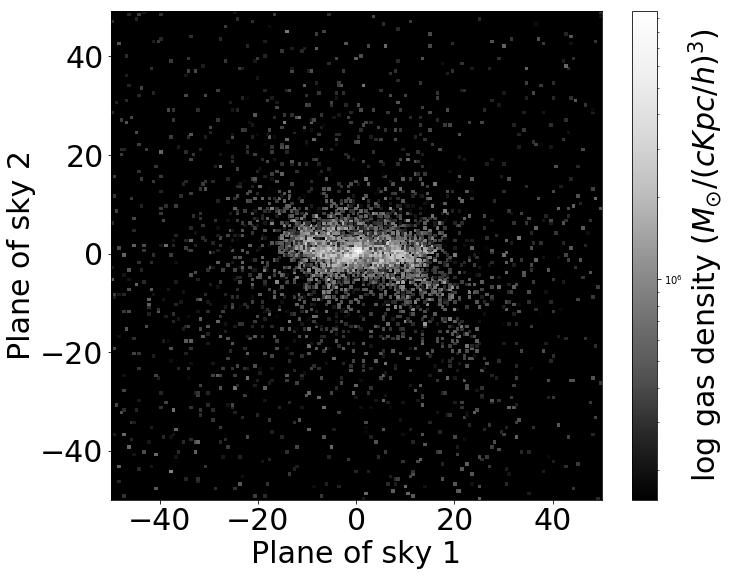

In [48]:
plane='xz'
bh_IDs,output_redshift=arepo_package.get_particle_property(basePath,'ParticleIDs',5,desired_redshift,list_all=False)
desired_center=find_BH_position(basePath,desired_redshift,p_id=bh_IDs[BH_index],choose_most_massive=0)
perpendicular_vector=stellar_ang_mom(basePath,desired_redshift,desired_center)
final_positions,final_property=extract_slice(basePath,0,desired_center,desired_redshift,planeofsky_dimensions=(100,100),lineofsight_dimension=20,plane=plane,orient=1)
final_property*=unit_conversions
final_property=='Density'
fig, ax = plt.subplots(1,1,figsize=(11,9))
ax.set_facecolor('xkcd:black')
visualize(final_positions,final_property,200,get_density=1)
ax.tick_params(labelsize=30)

/apps/jupyterhub/1.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


[    0.             0.             0.         ...     0.
     0.         43194.97859098]
making


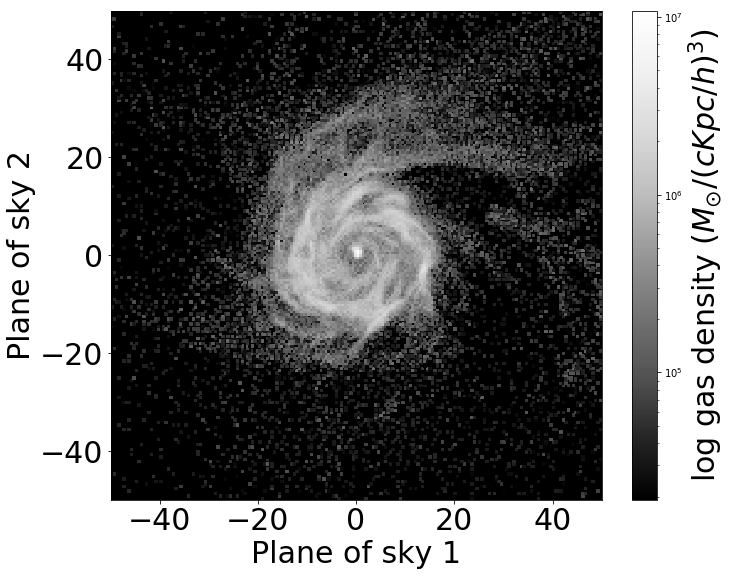

In [50]:
run='L25n128MUSIC_rerun_zoom_levelmax10_haloindex100_redshift0.00/AREPO'
basePath=path_to_run+run+'/output_BH_NGB_256/'
desired_redshift=0.2
unit_conversions=1e10
BH_index=0
plane='xy'
bh_IDs,output_redshift=arepo_package.get_particle_property(basePath,'ParticleIDs',5,desired_redshift,list_all=False)
desired_center=find_BH_position(basePath,desired_redshift,p_id=bh_IDs[BH_index],choose_most_massive=0)
perpendicular_vector=stellar_ang_mom(basePath,desired_redshift,desired_center)
final_positions,final_property=extract_slice(basePath,0,desired_center,desired_redshift,planeofsky_dimensions=(100,100),lineofsight_dimension=20,plane=plane,orient=1)
final_property*=unit_conversions
final_property=='Density'
fig, ax = plt.subplots(1,1,figsize=(11,9))
ax.set_facecolor('xkcd:black')
visualize(final_positions,final_property,200,get_density=1)
ax.tick_params(labelsize=30)

/apps/jupyterhub/1.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


[    0.         38197.93561972     0.         ...     0.
     0.             0.        ]
making


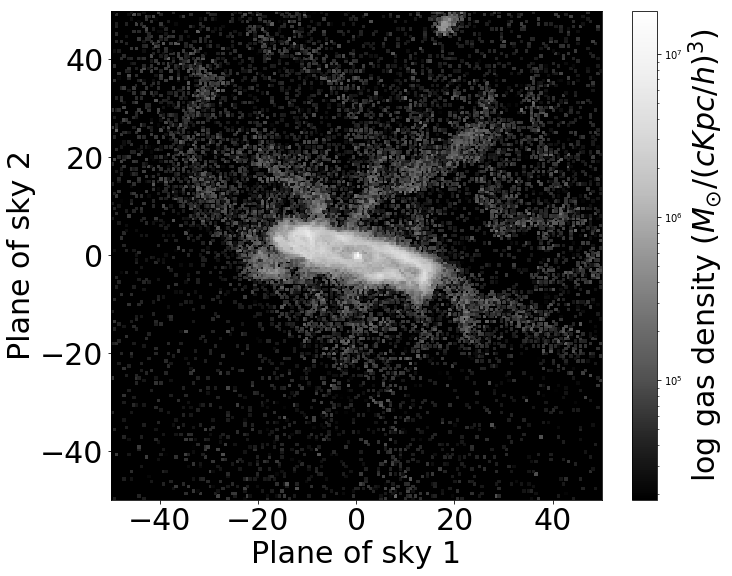

In [51]:
run='L25n128MUSIC_rerun_zoom_levelmax10_haloindex100_redshift0.00/AREPO'
basePath=path_to_run+run+'/output_BH_NGB_256/'
desired_redshift=0.2
unit_conversions=1e10
BH_index=0
plane='xz'
bh_IDs,output_redshift=arepo_package.get_particle_property(basePath,'ParticleIDs',5,desired_redshift,list_all=False)
desired_center=find_BH_position(basePath,desired_redshift,p_id=bh_IDs[BH_index],choose_most_massive=0)
perpendicular_vector=stellar_ang_mom(basePath,desired_redshift,desired_center)
final_positions,final_property=extract_slice(basePath,0,desired_center,desired_redshift,planeofsky_dimensions=(100,100),lineofsight_dimension=20,plane=plane,orient=1)
final_property*=unit_conversions
final_property=='Density'
fig, ax = plt.subplots(1,1,figsize=(11,9))
ax.set_facecolor('xkcd:black')
visualize(final_positions,final_property,200,get_density=1)
ax.tick_params(labelsize=30)

/apps/jupyterhub/1.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


[   0.            0.            0.         ...    0.            0.
 6361.33129466]
making


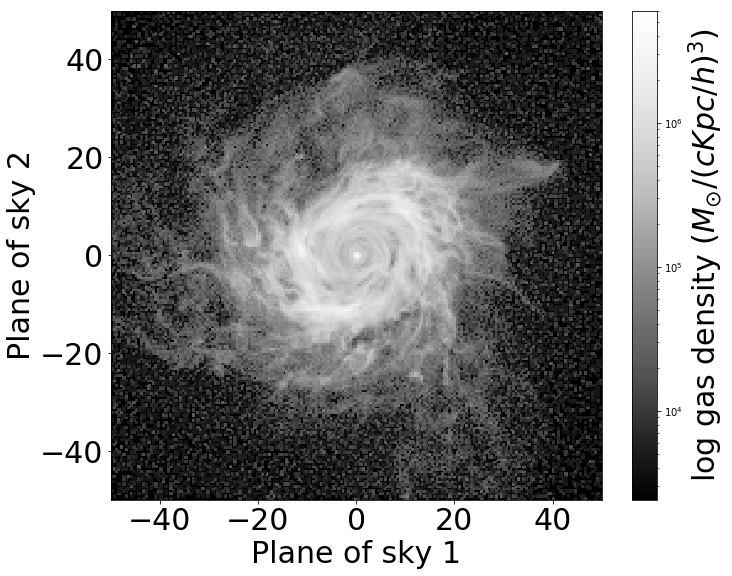

In [55]:
seed_bh_mass=8e5
min_FOF_seed_mass=5e10
run='L25n128MUSIC_rerun_zoom_levelmax11_haloindex100_redshift0.00_logbhseedmass%.2f_logFOFseedmass%.2f/AREPO'%(numpy.log10(seed_bh_mass),numpy.log10(min_FOF_seed_mass))
basePath=path_to_run+run+'/output_BH_NGB_256/'
desired_redshift=0.2
unit_conversions=1e10
BH_index=0
plane='xy'
bh_IDs,output_redshift=arepo_package.get_particle_property(basePath,'ParticleIDs',5,desired_redshift,list_all=False)
desired_center=find_BH_position(basePath,desired_redshift,p_id=bh_IDs[BH_index],choose_most_massive=0)
perpendicular_vector=stellar_ang_mom(basePath,desired_redshift,desired_center)
final_positions,final_property=extract_slice(basePath,0,desired_center,desired_redshift,planeofsky_dimensions=(100,100),lineofsight_dimension=20,plane=plane,orient=1)
final_property*=unit_conversions
final_property=='Density'
fig, ax = plt.subplots(1,1,figsize=(11,9))
ax.set_facecolor('xkcd:black')
visualize(final_positions,final_property,200,get_density=1)
ax.tick_params(labelsize=30)

/apps/jupyterhub/1.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


[   0.            0.            0.         ... 7609.21760751    0.
    0.        ]
making


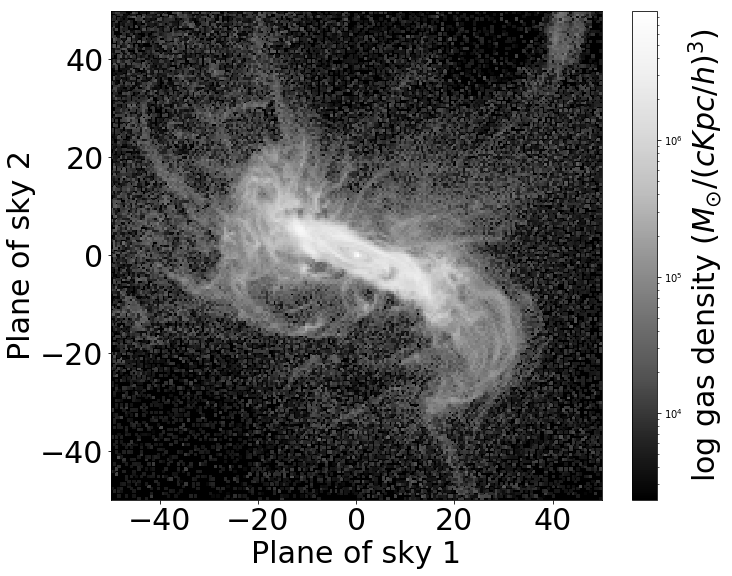

In [56]:
seed_bh_mass=8e5
min_FOF_seed_mass=5e10
run='L25n128MUSIC_rerun_zoom_levelmax11_haloindex100_redshift0.00_logbhseedmass%.2f_logFOFseedmass%.2f/AREPO'%(numpy.log10(seed_bh_mass),numpy.log10(min_FOF_seed_mass))
basePath=path_to_run+run+'/output_BH_NGB_256/'
desired_redshift=0.2
unit_conversions=1e10
BH_index=0
plane='xz'
bh_IDs,output_redshift=arepo_package.get_particle_property(basePath,'ParticleIDs',5,desired_redshift,list_all=False)
desired_center=find_BH_position(basePath,desired_redshift,p_id=bh_IDs[BH_index],choose_most_massive=0)
perpendicular_vector=stellar_ang_mom(basePath,desired_redshift,desired_center)
final_positions,final_property=extract_slice(basePath,0,desired_center,desired_redshift,planeofsky_dimensions=(100,100),lineofsight_dimension=20,plane=plane,orient=1)
final_property*=unit_conversions
final_property=='Density'
fig, ax = plt.subplots(1,1,figsize=(11,9))
ax.set_facecolor('xkcd:black')
visualize(final_positions,final_property,200,get_density=1)
ax.tick_params(labelsize=30)